In [5]:
from qdisk.model import Keplerian_velocity
from qdisk.classes import FitsImage
import eDiskplot as eplot
from qdisk.utils import is_within
from qdisk.plot import plot_channel_map, plot_2D_map
import analysis_utils as au
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
config = "SBLB"
line = "C18O"
robust = 1.0
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["v_sys"]

fit_vrange = [(1.5, 4.3), (9.8, 12.9)]
fit_region = (-1.5, 1.5)

imagename = au.customimagepath + au.get_image_basename(source, config, line, robust=robust)

image = FitsImage(imagename, xlim=fit_region, ylim=fit_region, vlim=(1.5, 12.9), downsample=False)
image.shift_phasecenter_toward(center_coord)
image.estimate_rms(edgenchan=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[None, (2.0, -2.0), (-2.0, 2.0)]

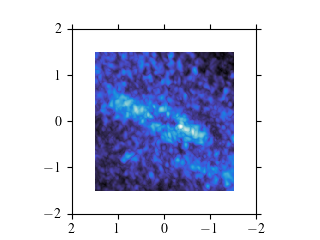

In [6]:
# check image data and make moment 0 by spectrally collapsing
fig, ax = plt.subplots()

# blue
image.spectrally_collapse(vrange=(1.5, 4.9), sigma_clip=None, mode="integ")
M0 = image.collapsed#[:, is_within(image.x, fit_region)][is_within(image.y, fit_region), :]
M1 = np.nanmax(image.data, axis=0)

# red
# image.spectrally_collapse(vrange=(9.8, 12.9), sigma_clip=None, mode="integ")
# M0 += image.collapsed#[:, is_within(image.x, fit_region)][is_within(image.y, fit_region), :]

# # measure the noise levels of collapsed
# image.get_mask(rmin=12, rmax=14)

noise = np.nanstd(image.collapsed)

plot_2D_map(
    M1,
    X=image.x,
    Y=image.y,
    ax=ax,
    cmap=True,
    cmap_method="pcolorfast",
    contour=False,
    # cmap=False,
    # contour=True,
    colorbar=False,
    beam=image.beam,
    beam_kw=dict(color="white", fill=True, linewidths=0.5),
    cmap_kw=dict(
        cmap=au.cmap["M0"]
        # levels=np.linspace(4 * noise, image.collapsed.max(), 4),
        # colors="red",
        # linewidths=0.5,
    ),
)

ax.set(aspect=1.0 / ax.get_data_ratio(), xlim=(2, -2), ylim=(-2, 2))



5.565044237682495


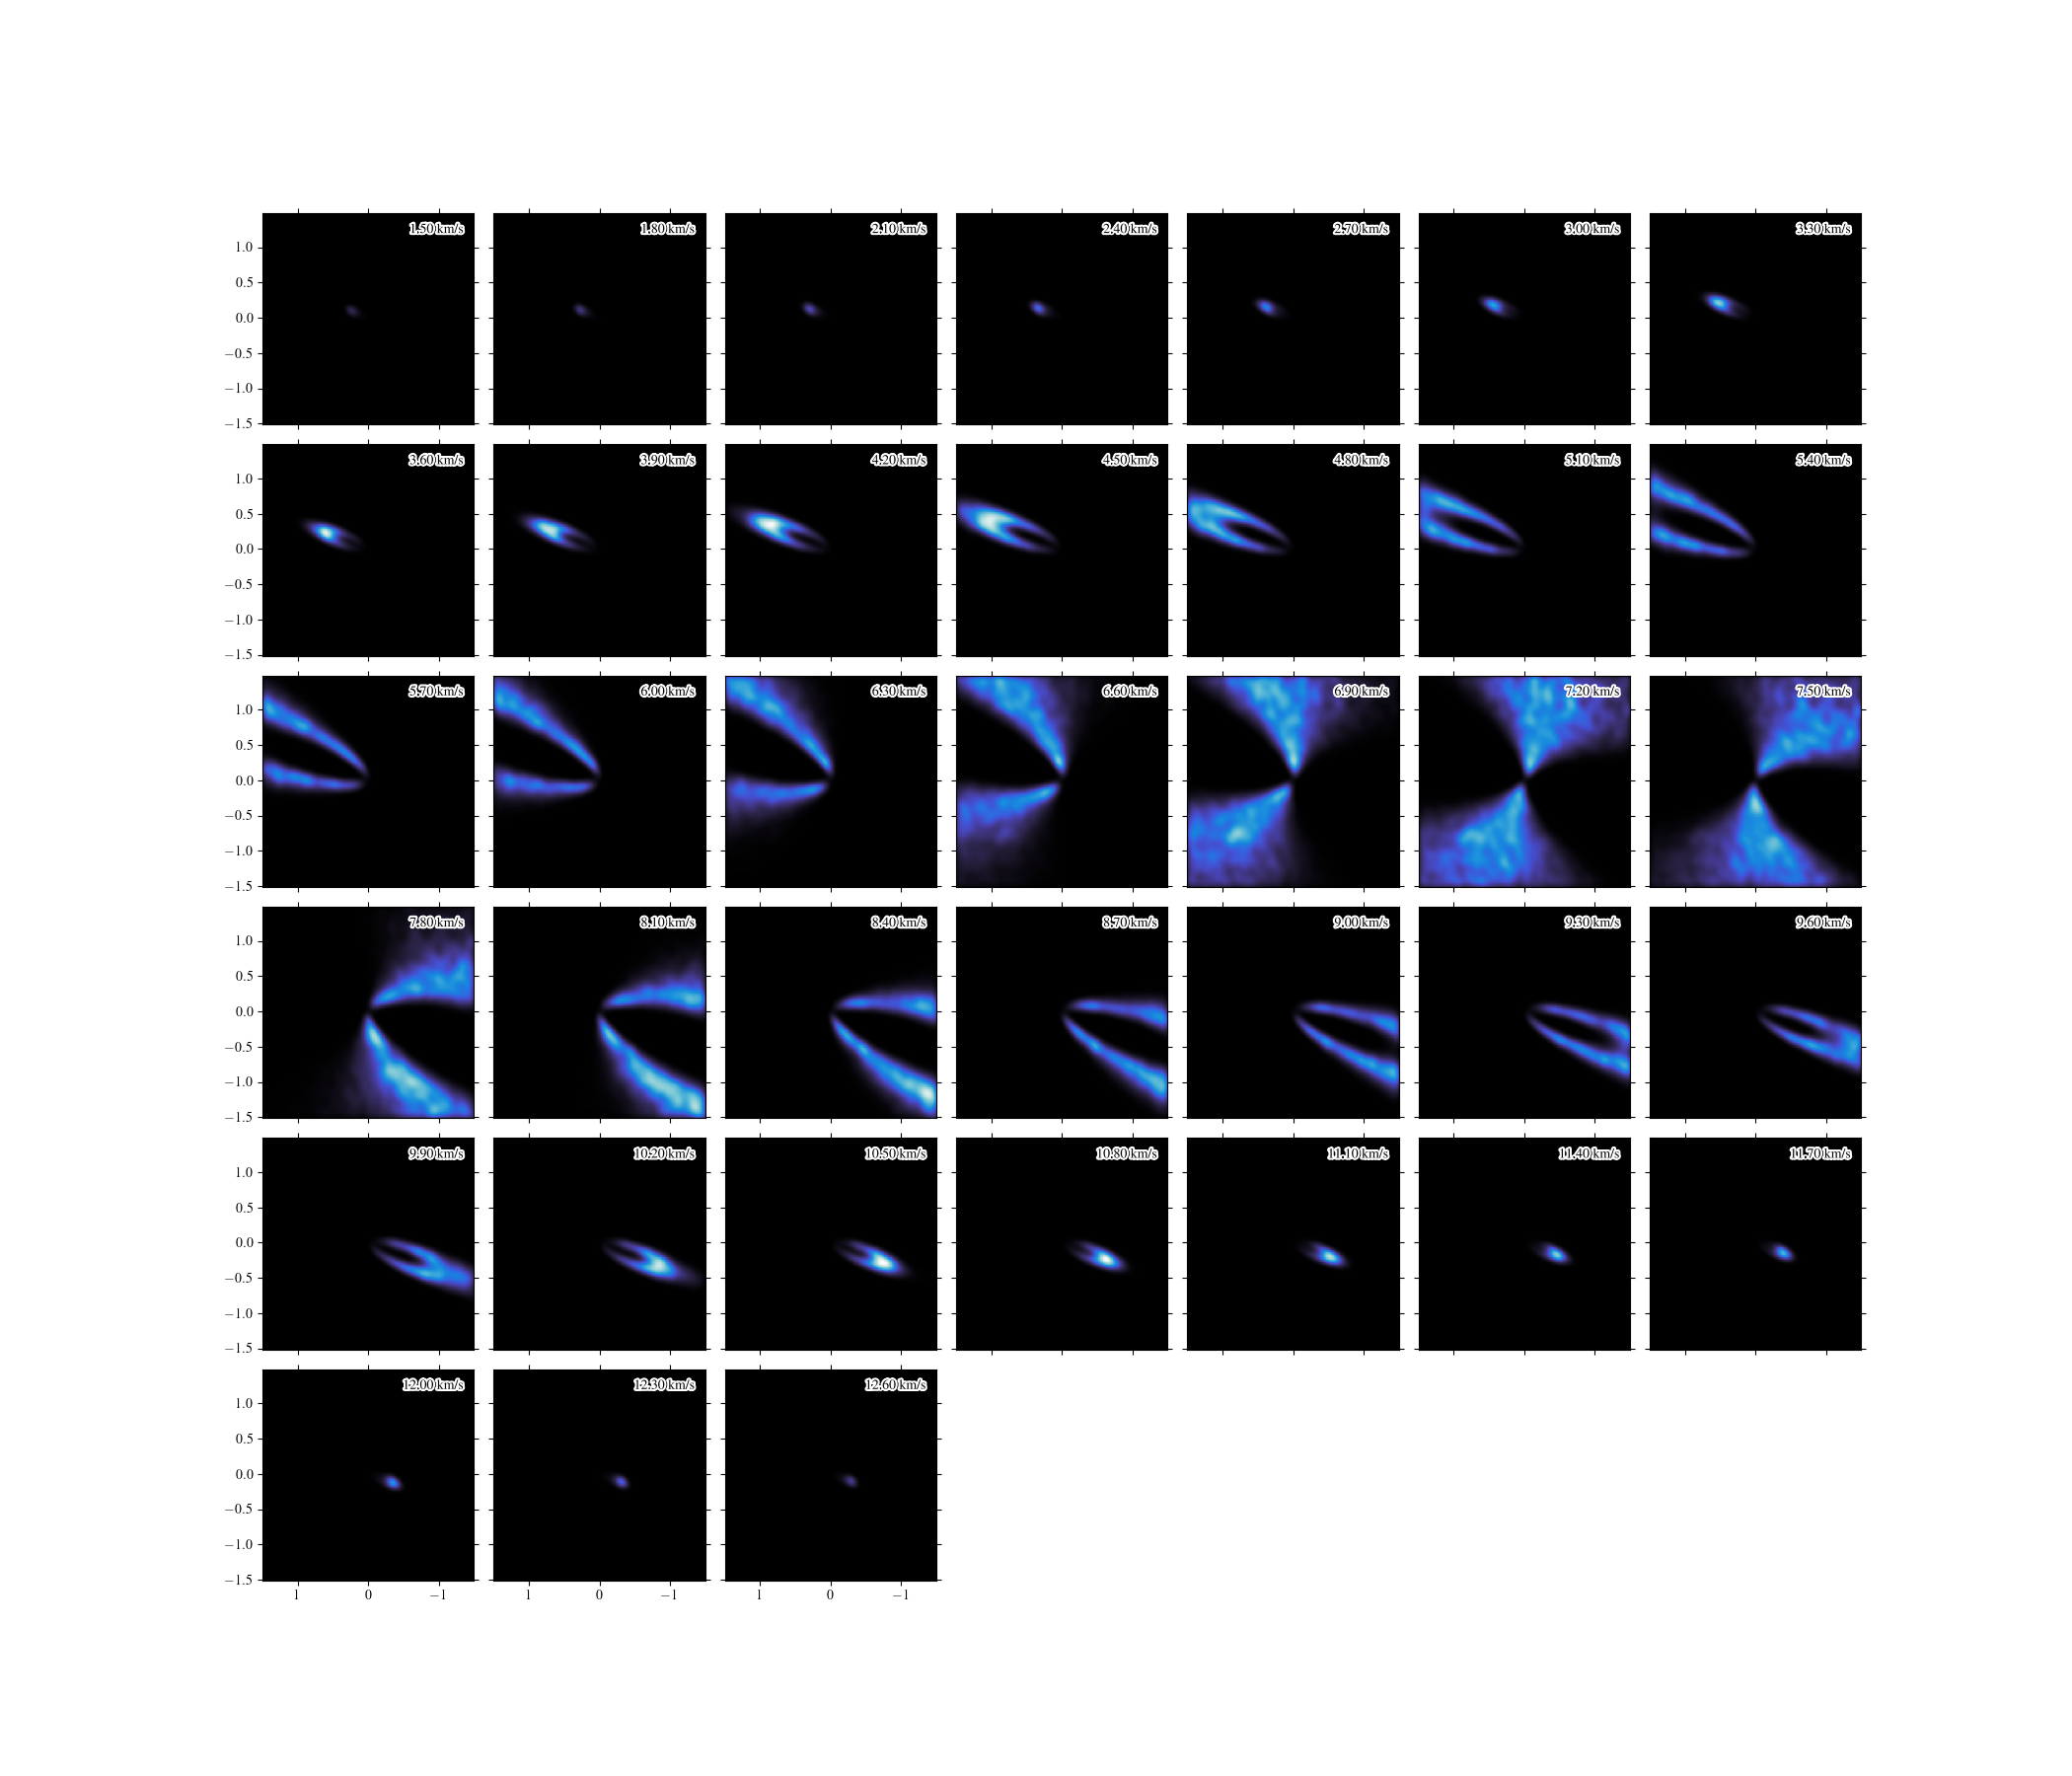

In [28]:
incl = 73
PA = 69
Mstar = 1.6
sigma = 0.3


from qdisk.plot import ChannelMap
from astropy.convolution import Gaussian2DKernel, convolve_fft
from analysis_utils import FWHM_to_sigma
print(FWHM_to_sigma(image.bmaj)/image.dpix)

kernel = Gaussian2DKernel(x_stddev=FWHM_to_sigma(image.bmaj)/image.dpix, y_stddev=FWHM_to_sigma(image.bmin)/image.dpix, theta=90 - image.bpa)

r, t = image.get_disk_coord(incl=incl, PA=PA, frame="polar")
vlos = - Keplerian_velocity(r, t, Mstar=Mstar, distance=distance, incl=incl) + vsys

# vlos = convolve_fft(vlos, kernel)

modelcube = M0 / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))
modelcube = M1 * np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))
modelcube = np.array([convolve_fft(im, kernel) for im in modelcube])

# plt.figure()
# plt.imshow(np.nanmax(modelcube, axis=0), origin="lower")

channelmap = ChannelMap(modelcube, x=image.x, y=image.y, v=image.v)
channelmap.set_imagegrid(colorbar=False, pad=0.2)
channelmap.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0)

In [12]:
def Keplerian_model(Mstar, PA, sigma, incl, vsys=7.22):
    r, t = image.get_disk_coord(incl=incl, PA=PA, frame="polar")
    vlos = - Keplerian_velocity(r, t, Mstar=Mstar, distance=distance, incl=incl) + vsys
    # vlos = convolve_fft(vlos, kernel)

    # modelcube = M0 / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))

    modelcube = M1 * np.exp(- (image.v[:, None, None] - vlos[None, :, :]) ** 2 / (2 * sigma ** 2))
    modelcube = np.array([convolve_fft(im, kernel) for im in modelcube])
    return modelcube
    

In [20]:
from mcmc_tools import log_prior, emcee_run_wrapper

# set up parameters
param = [1.6, 69, 1, 73]
bound = [(0.5, 10), (0, 90), (0.1, 5), (0, 90)]

def log_likelihood(param):
    model = Keplerian_model(*param)
    # compute log likelihood
    ll = -0.5 * np.sum((image.data - model) ** 2 / image.rms ** 2)

    return ll

def log_probability(param):
    lp = log_prior(param, bound)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(param)
    return lp + ll


In [21]:
import multiprocessing

with multiprocessing.Pool(16) as pool:
    sampler, sample = emcee_run_wrapper(log_probability=log_probability, initial_state=param, nstep=500, pool=pool)

starting to run the MCMC sampling with: 
 	 initial state: [1.6, 69, 1, 73] 
 	 number of walkers: 200 
 	 number of steps: 600 including 100 steps as burn in


100%|██████████| 600/600 [47:06<00:00,  4.71s/it]


In [22]:
sample_flat = sampler.get_chain(flat=True)

best_param = sample_flat[np.argmax(sampler.get_log_prob(flat=True))]
best_model = Keplerian_model(*best_param)

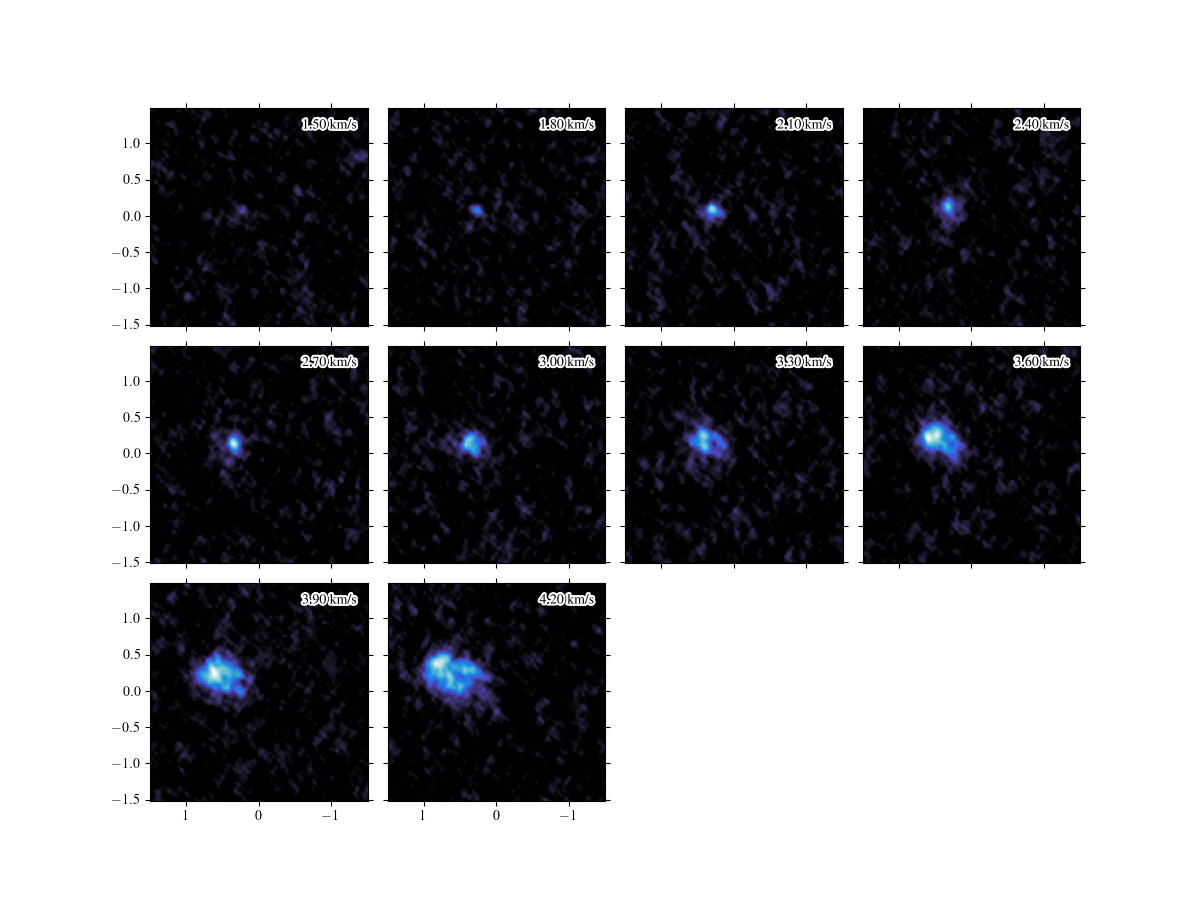

In [23]:
channelmap = ChannelMap(image.data, x=image.x, y=image.y, v=image.v)
channelmap.set_imagegrid(colorbar=False, pad=0.2)
channelmap.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0)

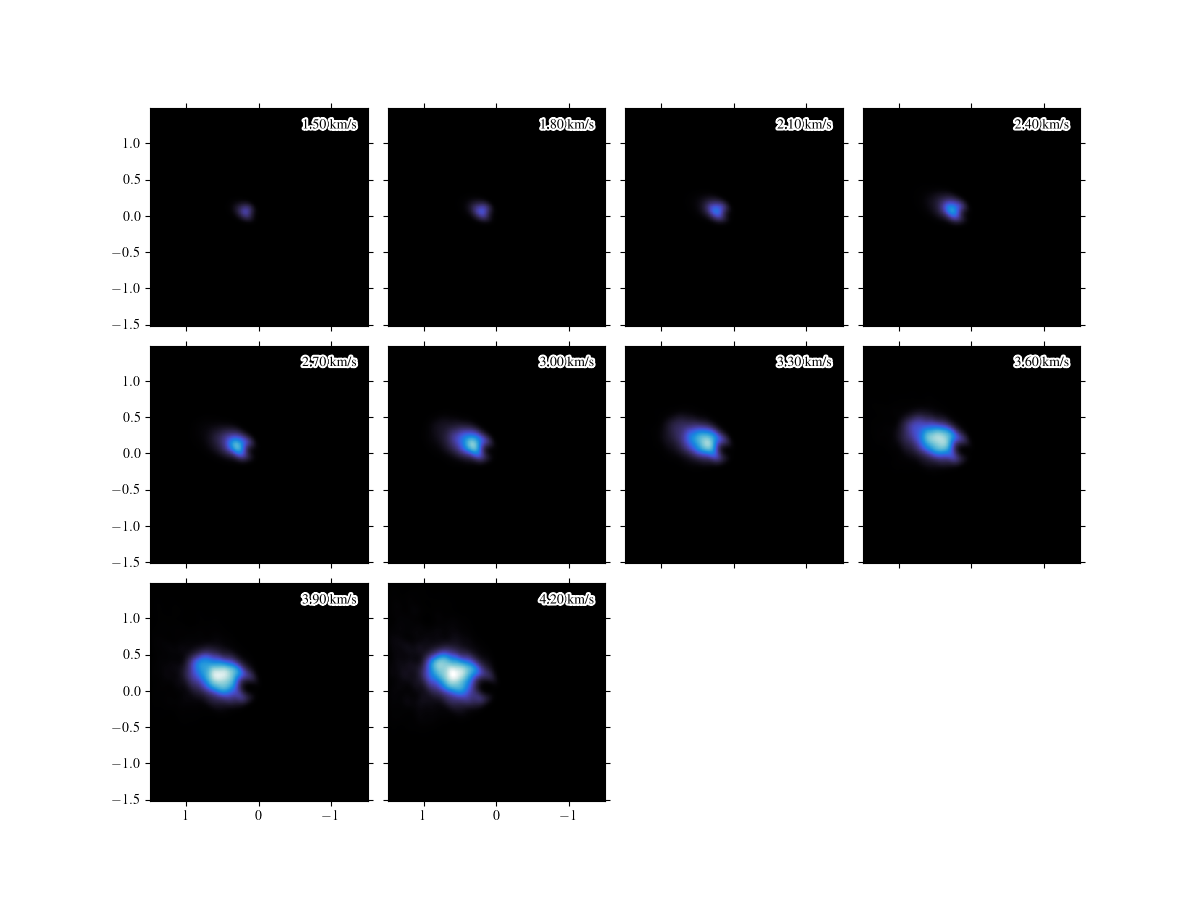

In [28]:
channelmap = ChannelMap(best_model, x=image.x, y=image.y, v=image.v)
channelmap.set_imagegrid(colorbar=False, pad=0.2)
channelmap.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0)

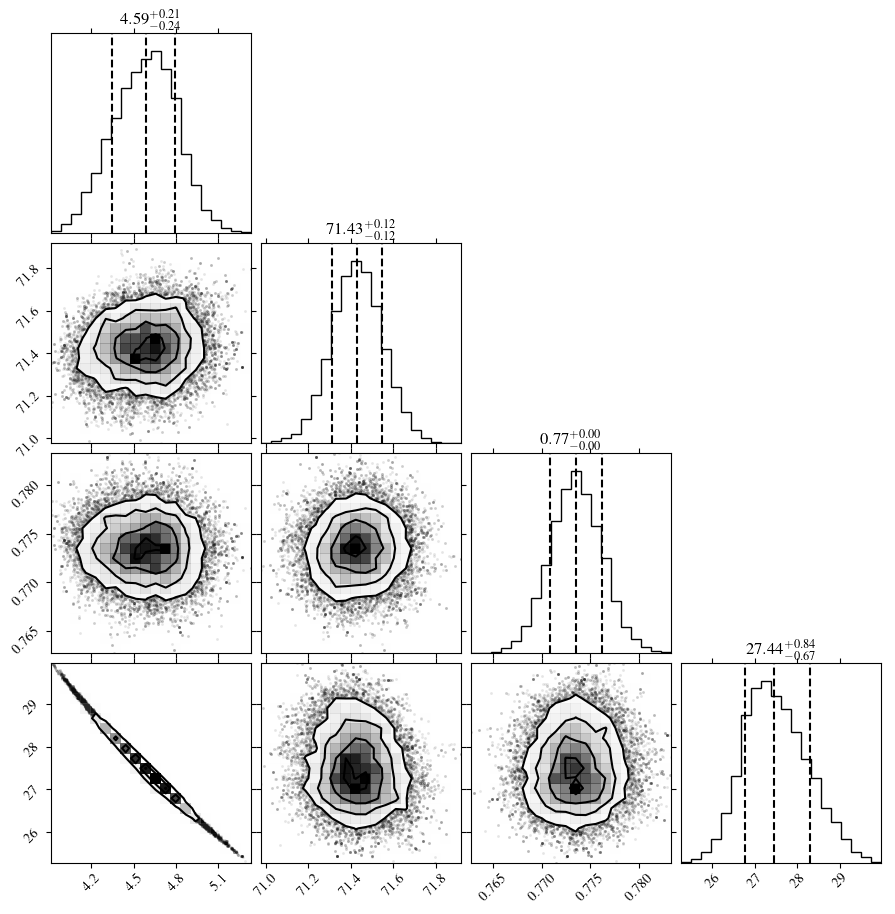

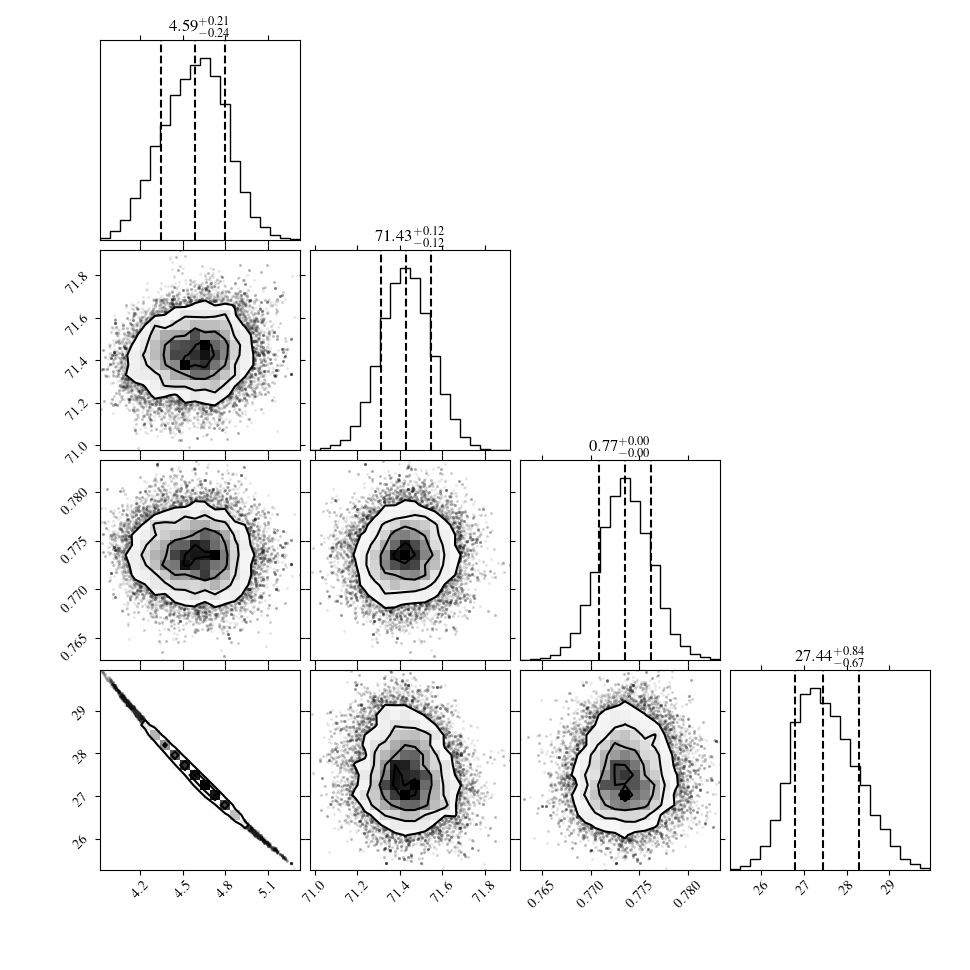

In [25]:
from mcmc_tools import plot_corner

plot_corner(sample[300:])

In [27]:
np.sin(np.radians(73)) / np.sin(np.radians(27)) * 1.6

3.3703075514105794